# Immune Landscape–Based Prediction of Breast Cancer Molecular Subtypes

## 1. Load & Prepare Data

Here we are loading CIBERSORT data with immune cells fractions and clinical data with breast cancer molecular subtypes. To be able to make one modeling table we need to prepare data accordingly, merge both tables, and filter breast cancer patients for future use.

In [117]:
import pandas as pd
import numpy as np
import sklearn

import seaborn as sns
from matplotlib import pyplot as plt

In [118]:
print(f'pandas=={pd.__version__}')
print(f'numpy=={np.__version__}')
print(f'sklearn=={sklearn.__version__}')

pandas==2.3.3
numpy==2.3.5
sklearn==1.8.0


### 1.1 Load clinical data for breast cancer samples

In [2]:
# Define the URL for the clinical dataset (BC Subtypes)
clin_data = 'https://raw.githubusercontent.com/ekhlebus/tme-breast-cancer-subtype-prediction/refs/heads/main/data/BRCA_clinicalMatrix.tsv'
clinical = pd.read_csv(clin_data, sep="\t")
clinical.shape

(1247, 194)

In [3]:
clinical.head(3)

,sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,NaN,TCGA-3C-AAAU-01A-11D-A41E-01,TCGA-3C-AAAU-01,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,TCGA-3C-AAAU-01A-11D-A41E-01,NaN
1,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,NaN,TCGA-3C-AALI-01A-11D-A41E-01,TCGA-3C-AALI-01,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,TCGA-3C-AALI-01A-11D-A41E-01,NaN
2,TCGA-3C-AALJ-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,NaN,TCGA-3C-AALJ-01A-31D-A41E-01,TCGA-3C-AALJ-01,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,TCGA-3C-AALJ-01A-31D-A41E-01,NaN


In [4]:
clinical.columns.tolist()

['sampleID',
 'AJCC_Stage_nature2012',
 'Age_at_Initial_Pathologic_Diagnosis_nature2012',
 'CN_Clusters_nature2012',
 'Converted_Stage_nature2012',
 'Days_to_Date_of_Last_Contact_nature2012',
 'Days_to_date_of_Death_nature2012',
 'ER_Status_nature2012',
 'Gender_nature2012',
 'HER2_Final_Status_nature2012',
 'Integrated_Clusters_no_exp__nature2012',
 'Integrated_Clusters_unsup_exp__nature2012',
 'Integrated_Clusters_with_PAM50__nature2012',
 'Metastasis_Coded_nature2012',
 'Metastasis_nature2012',
 'Node_Coded_nature2012',
 'Node_nature2012',
 'OS_Time_nature2012',
 'OS_event_nature2012',
 'PAM50Call_RNAseq',
 'PAM50_mRNA_nature2012',
 'PR_Status_nature2012',
 'RPPA_Clusters_nature2012',
 'SigClust_Intrinsic_mRNA_nature2012',
 'SigClust_Unsupervised_mRNA_nature2012',
 'Survival_Data_Form_nature2012',
 'Tumor_T1_Coded_nature2012',
 'Tumor_nature2012',
 'Vital_Status_nature2012',
 '_INTEGRATION',
 '_PANCAN_CNA_PANCAN_K8',
 '_PANCAN_Cluster_Cluster_PANCAN',
 '_PANCAN_DNAMethyl_BRCA',
 '_P

In [5]:
# Select ONLY necessary clinical columns
selected_cols = [
    'sampleID',
    'Age_at_Initial_Pathologic_Diagnosis_nature2012',
    'Gender_nature2012',
    'ER_Status_nature2012',
    'PR_Status_nature2012',
    'HER2_Final_Status_nature2012',
    'PAM50Call_RNAseq' # intrinsic subtype (our target variable)
]

clinical_sub = clinical.loc[:, clinical.columns.intersection(selected_cols)]

In [6]:
# Rename columns to cleaner names
clinical_sub = clinical_sub.rename(columns={
    'Age_at_Initial_Pathologic_Diagnosis_nature2012': 'age',
    'Gender_nature2012': 'gender',
    'ER_Status_nature2012': 'ER',
    'PR_Status_nature2012': 'PR',
    'HER2_Final_Status_nature2012': 'HER2',
    'PAM50Call_RNAseq': 'subtype'
})

In [7]:
clinical_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sampleID  1247 non-null   object 
 1   age       952 non-null    float64
 2   ER        782 non-null    object 
 3   gender    952 non-null    object 
 4   HER2      776 non-null    object 
 5   subtype   956 non-null    object 
 6   PR        781 non-null    object 
dtypes: float64(1), object(6)
memory usage: 68.3+ KB


In [8]:
clinical_sub.sampleID.nunique()

1247

In [9]:
clinical_sub.gender.value_counts(dropna=False)


gender
FEMALE    943
NaN       295
MALE        9
Name: count, dtype: int64

In [10]:
# Quick data quality check for age column
clinical_sub.age.describe()

count    952.000000
mean      57.720588
std       13.430495
min       26.000000
25%       48.000000
50%       58.000000
75%       66.250000
max       90.000000
Name: age, dtype: float64

In [11]:
clinical_sub.subtype.value_counts(dropna=False)

subtype
LumA      434
NaN       291
LumB      194
Basal     142
Normal    119
Her2       67
Name: count, dtype: int64

### 1.2 Load CIBERSORT data

In [12]:
# Define the URL for the immune profiles dataset (CIBERSORT)
tme_data = 'https://raw.githubusercontent.com/ekhlebus/tme-breast-cancer-subtype-prediction/refs/heads/main/data/TCGA.Kallisto.fullIDs.cibersort.relative.tsv'

In [13]:
cibersort = pd.read_csv(tme_data, sep="\t")
cibersort.shape

(11373, 27)

In [14]:
cibersort.head(3)

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
0,TCGA.OR.A5JG.01A.11R.A29S.07,ACC,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,...,0.363861,0.002715,0.026125,0.032788,0.00000,0.01029,0.009607,0.112,0.095797,1.047142
1,TCGA.OR.A5LG.01A.11R.A29S.07,ACC,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,...,0.448243,0.000000,0.007464,0.126237,0.00000,0.00000,0.000000,0.104,0.103345,1.046163
2,TCGA.OR.A5JD.01A.11R.A29S.07,ACC,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,...,0.329552,0.000000,0.009330,0.000000,0.19073,0.00000,0.000000,0.068,0.143259,1.039812


Extract sample-level TCGA ID and make new column with patient_id

CIBERSORT uses sub-sample-level barcodes, but clinical data is sample-level (first 15 symbols in SampleID).

In [15]:
cibersort["patient_id"] = cibersort.iloc[:, 0].str[:15]
cibersort[["SampleID", "patient_id"]].head(3)

,SampleID,patient_id
0,TCGA.OR.A5JG.01A.11R.A29S.07,TCGA.OR.A5JG.01
1,TCGA.OR.A5LG.01A.11R.A29S.07,TCGA.OR.A5LG.01
2,TCGA.OR.A5JD.01A.11R.A29S.07,TCGA.OR.A5JD.01


In [16]:
# replace "." with "-" in the patient_id column, since clinical data (below) uses "-" as separator
cibersort["patient_id"] = cibersort["patient_id"].str.replace(".", "-", regex=False)
cibersort[["SampleID", "patient_id"]].head(2)

,SampleID,patient_id
0,TCGA.OR.A5JG.01A.11R.A29S.07,TCGA-OR-A5JG-01
1,TCGA.OR.A5LG.01A.11R.A29S.07,TCGA-OR-A5LG-01


In [17]:
# Select only breast cancer samples
cibersort_brca = cibersort[cibersort.CancerType == "BRCA"]
cibersort_brca.head(3)

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,patient_id
512,TCGA.BH.A5J0.01A.11R.A27Q.07,BRCA,0.001898,0.023556,0.010481,0.095533,0.0,0.127552,0.0,0.095345,...,0.019468,0.00000,0.035999,0.000000,0.0,0.0,0.014,0.192839,1.008533,TCGA-BH-A5J0-01
513,TCGA.AR.A5QM.01A.11R.A27Q.07,BRCA,0.093505,0.000000,0.037465,0.096298,0.0,0.014914,0.0,0.054760,...,0.000000,0.00000,0.191294,0.006266,0.0,0.0,0.020,0.177653,1.013417,TCGA-AR-A5QM-01
514,TCGA.E9.A5FL.01A.11R.A27Q.07,BRCA,0.000000,0.076612,0.000323,0.073061,0.0,0.033787,0.0,0.065763,...,0.042529,0.00449,0.030624,0.000000,0.0,0.0,0.000,0.330051,0.952726,TCGA-E9-A5FL-01


In [18]:
cibersort_brca.SampleID.nunique(), cibersort_brca.patient_id.nunique()

(1232, 1215)

In [19]:
# Check duplicates in CIBERSORT
cibersort_brca['patient_id'].duplicated().sum()

np.int64(41)

In [20]:
# Check duplicated patients in cibersort data
cibersort_brca['patient_id'].value_counts().head(10)


patient_id
TCGA-A7-A0DC-01    6
TCGA-A7-A26F-01    5
TCGA-AC-A2QH-01    5
TCGA-AC-A3OD-01    5
TCGA-A7-A26I-01    5
TCGA-A7-A13G-01    5
TCGA-AC-A3QQ-01    4
TCGA-A7-A13D-01    3
TCGA-A7-A26J-01    3
TCGA-A7-A13E-01    3
Name: count, dtype: int64

Here we can see that cibersort contains multiple samples per patient! When merged we will see that one clinical row matches multiple CIBERSORT rows, what leads to duplicated clinical info. This is dangerous for ML, so we need to transform our data to have only one imput for each patient_id. In this case we will aggregate CIBERSORT immune fractions per patient.

In [21]:
non_cell_cols = [
    'SampleID', 'CancerType', 'P.value',
    'Correlation', 'RMSE', 'patient_id'
]

cell_cols = [c for c in cibersort.columns if c not in non_cell_cols]
print(len(cell_cols))
cell_cols


22


['B.cells.naive',
 'B.cells.memory',
 'Plasma.cells',
 'T.cells.CD8',
 'T.cells.CD4.naive',
 'T.cells.CD4.memory.resting',
 'T.cells.CD4.memory.activated',
 'T.cells.follicular.helper',
 'T.cells.regulatory..Tregs.',
 'T.cells.gamma.delta',
 'NK.cells.resting',
 'NK.cells.activated',
 'Monocytes',
 'Macrophages.M0',
 'Macrophages.M1',
 'Macrophages.M2',
 'Dendritic.cells.resting',
 'Dendritic.cells.activated',
 'Mast.cells.resting',
 'Mast.cells.activated',
 'Eosinophils',
 'Neutrophils']

Aggregate CIBERSORT per patient (MEAN)

In [22]:
cibersort_agg = (
    cibersort_brca
    .groupby('patient_id', as_index=False)[cell_cols]
    .mean()
)
cibersort_agg.shape

(1215, 23)

In [23]:
# Check duplicates in CIBERSORT after aggregation
cibersort_agg.patient_id.duplicated().sum()

np.int64(0)

### 1.3 Merge immune + clinical tables

In [24]:
clinical_sub.head(2)

,sampleID,age,ER,gender,HER2,subtype,PR
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
cibersort_agg.head(2)

,patient_id,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,...,Monocytes,Macrophages.M0,Macrophages.M1,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils
0,TCGA-3C-AAAU-01,0.048137,0.077700,0.150236,0.070180,0.028799,0.026362,0.0,0.085052,0.00000,...,0.015001,0.075029,0.022711,0.359493,0.000000,0.0,0.000000,0.000195,0.0,0.0
1,TCGA-3C-AALI-01,0.005145,0.027327,0.025370,0.234249,0.000000,0.047119,0.0,0.141624,0.09192,...,0.031447,0.122897,0.095969,0.080596,0.003228,0.0,0.060556,0.000000,0.0,0.0


In [26]:
clinical_sub.sampleID.nunique(), cibersort_agg.patient_id.nunique()

(1247, 1215)

In [27]:
df = clinical_sub.merge(cibersort_agg,
    left_on="sampleID",
    right_on="patient_id",
    how="inner"
)
df = df.drop(columns=['patient_id'])
print(df.shape)

df['sampleID'].duplicated().sum()


(1215, 29)


np.int64(0)

In [28]:
df.head(2)

,sampleID,age,ER,gender,HER2,subtype,PR,B.cells.naive,B.cells.memory,Plasma.cells,...,Monocytes,Macrophages.M0,Macrophages.M1,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,0.048137,0.077700,0.150236,...,0.015001,0.075029,0.022711,0.359493,0.000000,0.0,0.000000,0.000195,0.0,0.0
1,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN,0.005145,0.027327,0.025370,...,0.031447,0.122897,0.095969,0.080596,0.003228,0.0,0.060556,0.000000,0.0,0.0


## 2. Data preparation for modeling (cleaning, filtering) + initial EDA

In [29]:
df.head(3)

,sampleID,age,ER,gender,HER2,subtype,PR,B.cells.naive,B.cells.memory,Plasma.cells,...,Monocytes,Macrophages.M0,Macrophages.M1,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,0.048137,0.077700,0.150236,...,0.015001,0.075029,0.022711,0.359493,0.000000,0.0,0.000000,0.000195,0.0,0.0
1,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN,0.005145,0.027327,0.025370,...,0.031447,0.122897,0.095969,0.080596,0.003228,0.0,0.060556,0.000000,0.0,0.0
2,TCGA-3C-AALJ-01,NaN,NaN,NaN,NaN,NaN,NaN,0.071389,0.000000,0.011654,...,0.000000,0.188905,0.066825,0.206550,0.000000,0.0,0.013251,0.000000,0.0,0.0


Sometimes it is difficult to see all columns in a wide dataframe. To take a look at all columns we can transpose dataFrame, so rows become columns and now we can see them better.


In [30]:
df.head().T

,0,1,2,3,4
sampleID,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01
age,NaN,NaN,NaN,NaN,NaN
ER,NaN,NaN,NaN,NaN,NaN
gender,NaN,NaN,NaN,NaN,NaN
HER2,NaN,NaN,NaN,NaN,NaN
subtype,NaN,NaN,NaN,NaN,NaN
PR,NaN,NaN,NaN,NaN,NaN
B.cells.naive,0.048137,0.005145,0.071389,0.010297,0.070785
B.cells.memory,0.0777,0.027327,0.0,0.007828,0.0
Plasma.cells,0.150236,0.02537,0.011654,0.047802,0.050855


In [31]:
df.dtypes

sampleID                         object
age                             float64
ER                               object
gender                           object
HER2                             object
subtype                          object
PR                               object
B.cells.naive                   float64
B.cells.memory                  float64
Plasma.cells                    float64
T.cells.CD8                     float64
T.cells.CD4.naive               float64
T.cells.CD4.memory.resting      float64
T.cells.CD4.memory.activated    float64
T.cells.follicular.helper       float64
T.cells.regulatory..Tregs.      float64
T.cells.gamma.delta             float64
NK.cells.resting                float64
NK.cells.activated              float64
Monocytes                       float64
Macrophages.M0                  float64
Macrophages.M1                  float64
Macrophages.M2                  float64
Dendritic.cells.resting         float64
Dendritic.cells.activated       float64


Data for cell types and age are numerical as expected. No obvious data types errors.

Now let's consider features in more detailes. 

### 2.1 Immune cells

In [32]:
# Define immune cell features
immune_cols = [
    c for c in df.columns
    if c.startswith((
        "B.cells",
        "Plasma",
        "T.cells",
        "NK.cells",
        "Monocytes",
        "Macrophages",
        "Dendritic",
        "Mast.cells",
        "Eosinophils",
        "Neutrophils"
    ))
]

immune_cols, len(immune_cols)

(['B.cells.naive',
  'B.cells.memory',
  'Plasma.cells',
  'T.cells.CD8',
  'T.cells.CD4.naive',
  'T.cells.CD4.memory.resting',
  'T.cells.CD4.memory.activated',
  'T.cells.follicular.helper',
  'T.cells.regulatory..Tregs.',
  'T.cells.gamma.delta',
  'NK.cells.resting',
  'NK.cells.activated',
  'Monocytes',
  'Macrophages.M0',
  'Macrophages.M1',
  'Macrophages.M2',
  'Dendritic.cells.resting',
  'Dendritic.cells.activated',
  'Mast.cells.resting',
  'Mast.cells.activated',
  'Eosinophils',
  'Neutrophils'],
 22)

### 2.2 Subtype variable 
Now let's work with subtype variable (our target variable) and select samples only with subtype we are interested in.

In [33]:
# Check subtype values
df.subtype.value_counts(dropna=False)

subtype
LumA      434
NaN       262
LumB      194
Basal     140
Normal    118
Her2       67
Name: count, dtype: int64

In [34]:
# Filter to Basal vs Luminal only, Remove rare / noisy classes
df_sub = df[df["subtype"].isin([
    "Basal",
    "LumA",
    "LumB"
])].copy()

# Look at the target variable distribution
df_sub.subtype.value_counts()

subtype
LumA     434
LumB     194
Basal    140
Name: count, dtype: int64

In [35]:
# Create binary target variable
df_sub["y_target"] = df_sub["subtype"].map({
    "Basal": 1,
    "LumA": 0,
    "LumB": 0
})

In [36]:
df_sub["y_target"].value_counts(normalize=True)


y_target
0    0.817708
1    0.182292
Name: proportion, dtype: float64

We see **class imbalance** here.

Class imbalance consideration:
The dataset exhibits moderate class imbalance (≈18% Basal-like vs 82% Luminal). This reflects real-world subtype prevalence and intentionally preserved to maintain clinical realism. Model performance is therefore will be evaluated using ROC-AUC and class-specific precision/recall rather than accuracy alone. Stratified train–test splitting will be used to ensure consistent class proportions.

### 2.3 Age
Let's explore what we have for age.

In [37]:
# Check how many missing age values we have
df_sub.age.isnull().sum()

np.int64(43)

In [38]:
# Calculate the proportion of missing age values
df_sub.age.isna().mean()


np.float64(0.055989583333333336)

Since we have less than 10% missing values, we will replace them with median values.

In [39]:
# Let's replace missing age values with median values
df_sub["age"] = df_sub["age"].fillna(df_sub["age"].median())
df_sub.age.isna().mean()

np.float64(0.0)

### 2.4 Gender

In [40]:
# Check gender values
df_sub.gender.value_counts(dropna=False)

gender
FEMALE    716
NaN        43
MALE        9
Name: count, dtype: int64

In [41]:
# Check percentages of each gender
df_sub.gender.value_counts(normalize=True, dropna=False)

gender
FEMALE    0.932292
NaN       0.055990
MALE      0.011719
Name: proportion, dtype: float64

**Drop gender from the model**

Note: Gender was excluded from modeling due to extreme class imbalance (>93% female), limited biological relevance for breast cancer subtype differentiation, and non-trivial missingness. Including such a feature risks introducing noise without improving predictive performance.

### 2.5 What about ER / PR / HER2?

For now ER / PR / HER2 status will be not included as model features.

Note: Estrogen receptor (ER), progesterone receptor (PR), and HER2 status intentionally excluded from the primary model. These markers are closely related to the biological definitions of PAM50 breast cancer subtypes and are often used clinically to characterize or infer subtype membership. Including them as predictors would therefore introduce a risk of label leakage, artificially inflating model performance and obscuring the contribution of the immune microenvironment.

The goal of this analysis is to evaluate whether immune cell composition alone, with minimal clinical covariates, can distinguish Basal-like from Luminal breast cancer subtypes. ER/PR/HER2 may be explored separately in sensitivity analyses but are excluded from the main modeling pipeline.

## 3. Train / Test Split + EDA for training data

### 3.1 Splitting the data

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
df_sub.T

,9,10,11,12,13,14,15,16,17,18,...,1116,1118,1120,1121,1122,1123,1124,1125,1127,1134
sampleID,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,TCGA-A1-A0SN-01,...,TCGA-GM-A2DC-01,TCGA-GM-A2DF-01,TCGA-GM-A2DI-01,TCGA-GM-A2DK-01,TCGA-GM-A2DL-01,TCGA-GM-A2DM-01,TCGA-GM-A2DN-01,TCGA-GM-A2DO-01,TCGA-GM-A3NY-01,TCGA-HN-A2NL-01
age,59.0,56.0,54.0,61.0,39.0,52.0,39.0,54.0,77.0,50.0,...,57.0,53.0,52.0,58.0,50.0,57.0,58.0,54.0,58.0,58.0
ER,Positive,Positive,Positive,Positive,Negative,Positive,Positive,Negative,Positive,Positive,...,Positive,Negative,Negative,Positive,Positive,Positive,Positive,Positive,NaN,NaN
gender,FEMALE,FEMALE,FEMALE,FEMALE,FEMALE,FEMALE,FEMALE,FEMALE,MALE,FEMALE,...,FEMALE,FEMALE,FEMALE,FEMALE,FEMALE,FEMALE,FEMALE,FEMALE,NaN,NaN
HER2,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Positive,Positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subtype,LumA,LumA,LumA,LumA,LumA,LumB,LumA,Basal,LumA,LumB,...,LumA,Basal,LumA,LumA,LumA,LumA,LumA,LumB,LumA,Basal
PR,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive,...,Positive,Negative,Negative,Negative,Positive,Positive,Positive,Positive,NaN,NaN
B.cells.naive,0.06808,0.102752,0.113071,0.19085,0.114389,0.073011,0.068413,0.032865,0.005112,0.056147,...,0.065363,0.034552,0.053933,0.043746,0.009064,0.01916,0.065164,0.232752,0.184154,0.043953
B.cells.memory,0.0,0.0,0.0,0.076242,0.0,0.0,0.0,0.055234,0.037588,0.0,...,0.0,0.0263,0.009846,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Plasma.cells,0.037843,0.048831,0.154488,0.012071,0.095973,0.041396,0.096088,0.061789,0.0,0.010754,...,0.047856,0.111629,0.0,0.01395,0.010231,0.006636,0.01848,0.032781,0.131968,0.040203


In [44]:
# Define final df
df_full = df_sub[immune_cols + ["age"] + ["y_target"]]

In [45]:
df_full.shape

(768, 24)

Since we have class imbalance, let's make next split:
* TRAIN - 75%
* TEST - 25%

Since we have class imbalance, let's use stratify parameter.
Use stratified train/test split. This ensures both sets reflect the same imbalance.

In [46]:
# Split the dataset into training and testing sets
df_train_full, df_test = train_test_split(
    df_full,
    test_size=0.25,
    random_state=1,
    stratify=df_full["y_target"]
)

# test_size=0.25 - setting aside 25% of the data for testing
# random_state=1 - setting a seed for reproducibility

In [47]:
len(df_train_full), len(df_test)

(576, 192)

In [48]:
df_train_full.head(3)

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Macrophages.M1,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,age,y_target
1016,0.041715,0.0,0.041324,0.038659,0.0,0.141092,0.0,0.000000,0.000000,0.002849,...,0.086497,0.375007,0.012854,0.000000,0.104697,0.0,0.0,0.007432,63.0,0
775,0.124253,0.0,0.098939,0.164784,0.0,0.095450,0.0,0.086921,0.051362,0.000000,...,0.060741,0.166181,0.016537,0.004022,0.016495,0.0,0.0,0.000000,56.0,0
761,0.062756,0.0,0.027437,0.179353,0.0,0.138612,0.0,0.118817,0.015698,0.019575,...,0.040584,0.105119,0.000000,0.000000,0.195936,0.0,0.0,0.003178,70.0,0


In [49]:
# Indexes have been reset for both training and testing sets
df_train_full = df_train_full.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [50]:
df_train_full.head(3)

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Macrophages.M1,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,age,y_target
0,0.041715,0.0,0.041324,0.038659,0.0,0.141092,0.0,0.000000,0.000000,0.002849,...,0.086497,0.375007,0.012854,0.000000,0.104697,0.0,0.0,0.007432,63.0,0
1,0.124253,0.0,0.098939,0.164784,0.0,0.095450,0.0,0.086921,0.051362,0.000000,...,0.060741,0.166181,0.016537,0.004022,0.016495,0.0,0.0,0.000000,56.0,0
2,0.062756,0.0,0.027437,0.179353,0.0,0.138612,0.0,0.118817,0.015698,0.019575,...,0.040584,0.105119,0.000000,0.000000,0.195936,0.0,0.0,0.003178,70.0,0


In [51]:
y_train = df_train_full.y_target.values
y_test = df_test.y_target.values

df_train = df_train_full.drop(columns=["y_target"])
df_test = df_test.drop(columns=["y_target"])

In [52]:
n_basal = (y_test == 1).sum()
n_total = len(y_test)

print(f"Basal-like cases in test set: {n_basal} / {n_total} ({n_basal / n_total:.1%})")


Basal-like cases in test set: 35 / 192 (18.2%)


The stratified split resulted in sufficient representation of the Basal-like subtype in the test set.

In [53]:
# Verify values:
print(pd.Series(y_train).value_counts(normalize=False))
print()
print(pd.Series(y_test).value_counts(normalize=False))

0    471
1    105
Name: count, dtype: int64

0    157
1     35
Name: count, dtype: int64


In [54]:
# Verify balance:
print(pd.Series(y_train).value_counts(normalize=True))
print()
print(pd.Series(y_test).value_counts(normalize=True))

0    0.817708
1    0.182292
Name: proportion, dtype: float64

0    0.817708
1    0.182292
Name: proportion, dtype: float64


Train–test split explanation:
The dataset was split into 75% training and 25% testing sets using stratified sampling. This proportion provides sufficient training data for stable model estimation while ensuring an adequate number of Basal-like cases (minority class) in the test set.

### 3.2 Feature scaling

Immune fractions are on similar scales (from 0 to 1), but age is not, so we scale everything.

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train)
X_test = scaler.transform(df_test)


In [57]:
len(X_train), len(X_test)

(576, 192)

### 3.3 Checking missing values (EDA)

Here we will use our full train dataset

In [58]:
df_train.head(3)

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Macrophages.M0,Macrophages.M1,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,age
0,0.041715,0.0,0.041324,0.038659,0.0,0.141092,0.0,0.000000,0.000000,0.002849,...,0.126154,0.086497,0.375007,0.012854,0.000000,0.104697,0.0,0.0,0.007432,63.0
1,0.124253,0.0,0.098939,0.164784,0.0,0.095450,0.0,0.086921,0.051362,0.000000,...,0.110710,0.060741,0.166181,0.016537,0.004022,0.016495,0.0,0.0,0.000000,56.0
2,0.062756,0.0,0.027437,0.179353,0.0,0.138612,0.0,0.118817,0.015698,0.019575,...,0.027083,0.040584,0.105119,0.000000,0.000000,0.195936,0.0,0.0,0.003178,70.0


In [59]:
# Let's look for missing values in the full training set
df_train.isnull().sum()

B.cells.naive                   0
B.cells.memory                  0
Plasma.cells                    0
T.cells.CD8                     0
T.cells.CD4.naive               0
T.cells.CD4.memory.resting      0
T.cells.CD4.memory.activated    0
T.cells.follicular.helper       0
T.cells.regulatory..Tregs.      0
T.cells.gamma.delta             0
NK.cells.resting                0
NK.cells.activated              0
Monocytes                       0
Macrophages.M0                  0
Macrophages.M1                  0
Macrophages.M2                  0
Dendritic.cells.resting         0
Dendritic.cells.activated       0
Mast.cells.resting              0
Mast.cells.activated            0
Eosinophils                     0
Neutrophils                     0
age                             0
dtype: int64

No missing values! So don't need to do any additional data preparation steps.

In [60]:
df_train.dtypes

B.cells.naive                   float64
B.cells.memory                  float64
Plasma.cells                    float64
T.cells.CD8                     float64
T.cells.CD4.naive               float64
T.cells.CD4.memory.resting      float64
T.cells.CD4.memory.activated    float64
T.cells.follicular.helper       float64
T.cells.regulatory..Tregs.      float64
T.cells.gamma.delta             float64
NK.cells.resting                float64
NK.cells.activated              float64
Monocytes                       float64
Macrophages.M0                  float64
Macrophages.M1                  float64
Macrophages.M2                  float64
Dendritic.cells.resting         float64
Dendritic.cells.activated       float64
Mast.cells.resting              float64
Mast.cells.activated            float64
Eosinophils                     float64
Neutrophils                     float64
age                             float64
dtype: object

We are doing this to double check which columns are categorical and which are numerical. All columns are numerical, and before that we don't need one-hot encoding and DictVectorizer.


In [61]:
# Let's look at the target variable distribution (proportion of classes)
pd.Series(y_train).value_counts(normalize=True)

0    0.817708
1    0.182292
Name: proportion, dtype: float64

### 3.4 Feature Importance: Correlation

This is a way to measure Feature Importance to **numerical** vatiables. And here we are talking about Pearson's correlation - this is way to measure dependency between two variables.

Pearson correlation coefficient (r) - https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

-1 <= r <= 1

In our case:
* y = 0 or y = 1 - binary subtype

So, since y is binary, we will use point-biserial correlation, which is numerically equivalent to Pearson.

In [62]:
df_train_full['age'].corr(df_train_full.y_target)

np.float64(-0.07131125567669651)

In [63]:
corr_df = df_train_full.drop(columns=['y_target', 'age']).corrwith(df_train_full.y_target).to_frame('correlation')
corr_df.head(5)

,correlation
B.cells.naive,0.006555
B.cells.memory,0.067545
Plasma.cells,-0.014879
T.cells.CD8,0.041490
T.cells.CD4.naive,-0.002240


In [64]:
corr_df_sorted = corr_df.sort_values('correlation')
corr_df_sorted.head(3)

,correlation
Mast.cells.resting,-0.377468
Macrophages.M2,-0.266213
Neutrophils,-0.087186


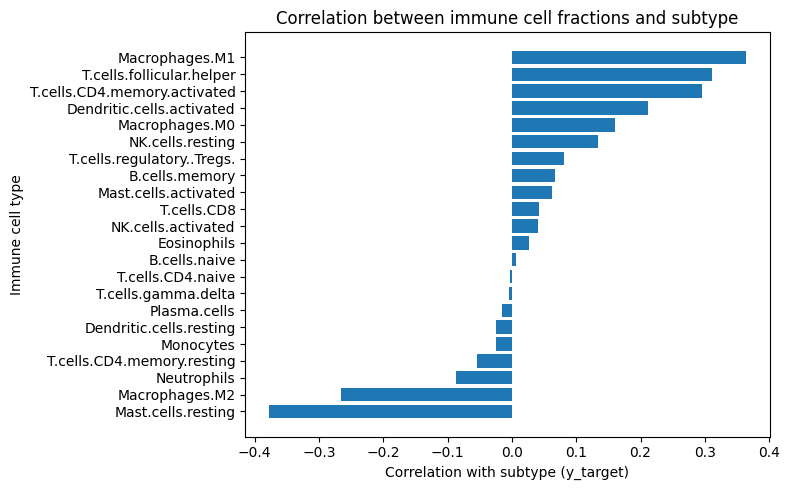

In [65]:
plt.figure(figsize=(8, 5))
plt.barh(corr_df_sorted.index, corr_df_sorted['correlation'])
plt.xlabel("Correlation with subtype (y_target)")
plt.ylabel("Immune cell type")
plt.title("Correlation between immune cell fractions and subtype")
plt.tight_layout()
plt.show()

## 4. Training Logistic Regression with Scikit-Learn

* Train a model with Scikit-Learn
* Apply it to the test dataset

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
# Create the model
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    #solver='liblinear', 
    random_state=1)

# Train the model with dataset, created earlier
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",1
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`

In [73]:
# The value of the model output when all features are zero
model.intercept_[0]

np.float64(-1.7461879481565035)

In [69]:
# Let's look inside the model, this is how we can access the weights
model.coef_[0].round(3)

array([ 0.047,  0.263,  0.186, -0.297, -0.051,  0.075,  0.457,  0.342,
       -0.164, -0.281,  0.031,  0.2  ,  0.358,  0.791,  0.95 , -0.322,
        0.173,  0.857, -2.14 , -0.03 ,  0.256, -0.228, -0.256])

In [74]:
# let's use the model and get HARD predictions (1 - Basal, 0 - Luminal)
model.predict(X_train)

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,

In [78]:
# Also we can get SOFT predictions with probabilities
model.predict_proba(X_train)
# First column in this 2D array is the probability of class 0 (Luminal)
# Second column is the probability of class 1 (Basal)

array([[9.68991116e-01, 3.10088841e-02],
       [5.75541179e-01, 4.24458821e-01],
       [9.99114980e-01, 8.85020201e-04],
       ...,
       [8.29011122e-01, 1.70988878e-01],
       [4.92884537e-01, 5.07115463e-01],
       [8.32151696e-01, 1.67848304e-01]], shape=(576, 2))

In [81]:
y_pred_proba = model.predict_proba(X_train)[:, 1]
#y_pred_proba

In [82]:
# Using those predicted probabilities, we can set up a custom threshold
y_pred = (model.predict_proba(X_train)[:, 1] >= 0.3).astype(int)
#y_pred

Now we have our predictions. Let's check how accurate they are.

## 5. Measure performance of the model

To measure performance of our model we will use next metrics:

* Accuracy - it tells us how many correct predictions we made (not the best approach because of class imbalance, just for sanity check)
* ROC-AUC (primary metric)
* Confusion matrix
* ROC curve

### 5.1 Accuracy

Let's see how many actual subtype values and predicted values match and compare train vs test accuracy.

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = (y_train == y_train_pred).mean()
test_accuracy = (y_test == y_test_pred).mean()  

print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy:  {test_accuracy:.3f}")

Train Accuracy: 0.858
Test Accuracy:  0.885


Note: Accuracy is reported for completeness but is not the primary evaluation metric due to class imbalance (~18% Basal-like). A model predicting only the majority class would achieve high accuracy without meaningful discrimination. Therefore, ROC-AUC and class-specific recall are emphasized in subsequent evaluation.

Here we used 0.5 threshold, but is it good or not?

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
thresholds = np.linspace(0, 1, 11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
# function to check different thresholds
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_test, y_test_pred >= t) # from sklearn.metrics
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.182
0.05 0.885
0.10 0.885
0.15 0.885
0.20 0.885
0.25 0.885
0.30 0.885
0.35 0.885
0.40 0.885
0.45 0.885
0.50 0.885
0.55 0.885
0.60 0.885
0.65 0.885
0.70 0.885
0.75 0.885
0.80 0.885
0.85 0.885
0.90 0.885
0.95 0.885
1.00 0.885


Using accuracy is not the best way to evaluate our model as expected! 

So accuracy is a score that for cases with class imbalance can be misleading. In such cases it is useful to use other metrics and different way of eveluation a quality of our model, that is not affected by class imbalance.

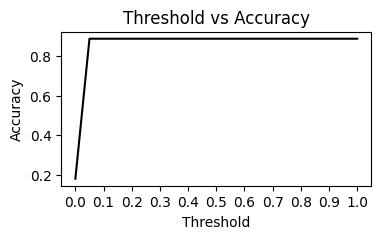

In [95]:
plt.figure(figsize=(4, 2))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

### 5.2 ROC-AUC

Due to class imbalance between Basal-like and Luminal tumors, ROC-AUC is used as the primary evaluation metric, as it measures discrimination across all classification thresholds and is not biased by class prevalence.

In [102]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"Test ROC-AUC: {roc_auc:.3f}")

# For diagnostic purposes, we can also look at train ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_train_pred)
print(f"Train ROC-AUC: {roc_auc_train:.3f}")

Test ROC-AUC: 0.863
Train ROC-AUC: 0.865


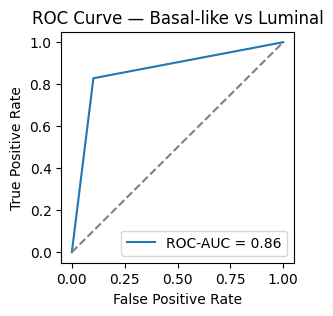

In [99]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Basal-like vs Luminal")
plt.legend()
plt.show()


In [101]:
np.unique(y_test_pred).shape


(2,)

## 6. Model interpretation

* Look at the model coefficients
* Convert coefficients to odds ratios

In [103]:
# Extract model coefficients
model.coef_[0].round(3)

array([ 0.047,  0.263,  0.186, -0.297, -0.051,  0.075,  0.457,  0.342,
       -0.164, -0.281,  0.031,  0.2  ,  0.358,  0.791,  0.95 , -0.322,
        0.173,  0.857, -2.14 , -0.03 ,  0.256, -0.228, -0.256])

In [107]:
coef_df = pd.DataFrame({
    "feature": df_full.columns.drop("y_target"),
    "coefficient": model.coef_[0]
})

coef_df = coef_df.sort_values("coefficient", ascending=False)
coef_df

,feature,coefficient
14,Macrophages.M1,0.949719
17,Dendritic.cells.activated,0.857279
13,Macrophages.M0,0.790533
6,T.cells.CD4.memory.activated,0.457488
12,Monocytes,0.358354
7,T.cells.follicular.helper,0.341872
1,B.cells.memory,0.263406
20,Eosinophils,0.255916
11,NK.cells.activated,0.199977
2,Plasma.cells,0.185863


Interpretation:

* Positive coefficient → higher probability of Basal-like
* Negative coefficient → higher probability of Luminal

In [110]:
# Convert coefficients to odds ratios
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df.head(3)


,feature,coefficient,odds_ratio
14,Macrophages.M1,0.949719,2.584982
17,Dendritic.cells.activated,0.857279,2.356738
13,Macrophages.M0,0.790533,2.204570


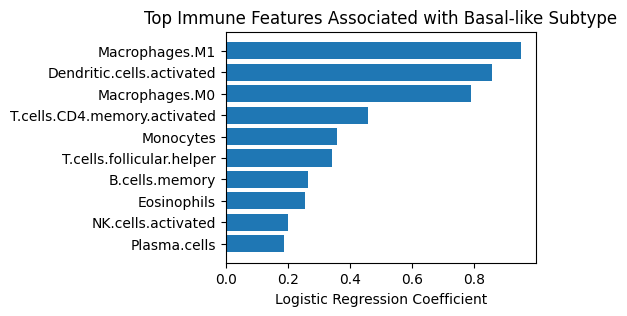

In [ ]:
top_features = coef_df.head(10)

plt.figure(figsize=(4, 3))
plt.barh(top_features["feature"], top_features["coefficient"])
plt.gca().invert_yaxis()
plt.xlabel("Logistic Regression Coefficient")
plt.title("Top Immune Features Associated with Basal-like Subtype")
plt.show()

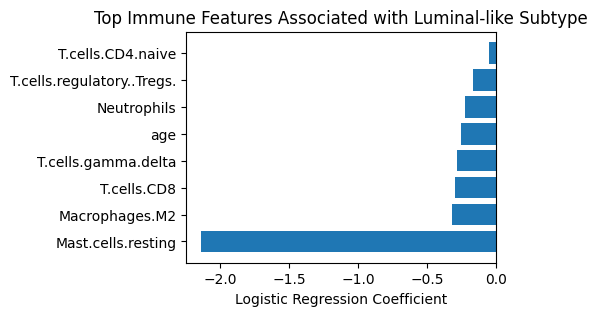

In [115]:
bottom_features = coef_df.tail(8)

plt.figure(figsize=(4, 3))
plt.barh(bottom_features["feature"], bottom_features["coefficient"])
plt.gca().invert_yaxis()
plt.xlabel("Logistic Regression Coefficient")
plt.title("Top Immune Features Associated with Luminal-like Subtype")
plt.show()

The model identifies higher abundance of macrophages (M0/M1), dendritic cells, and CD4 T-cell populations as positively associated with the Basal-like subtype, while mast cells are more strongly associated with Luminal tumors. These findings are consistent with published analyses of TCGA breast cancer, which report increased immune infiltration and antigen-presenting cell activity in Basal-like tumors, and enrichment of mast cells in hormone receptor–positive Luminal subtypes.

Importantly, these associations emerged without using tumor-intrinsic molecular markers, suggesting that immune context alone captures subtype-specific biology.

## 7. Saving the model

In [ ]:
import pickle

In [121]:
# Save our model into a file called model.bin
with open('model.bin', 'wb') as f_out:
    pickle.dump(model, f_out)    